# LLMs and Pirates 🏴‍☠️🦜⚓
The theme is of a pirate-y nature. If ye be havin' any wonderings about what a life in the seas be like, yer in the right place, matey. Arrr!

This notebook demonstrates use of 
- LLM APIs: OpenAI ChatGPT, Anthropic Claude, Google Gemini
- Gradio to build some UIs to test out the LLMs
- Streaming mode for LLM output
- Text-to-speech via OpenAI's TTS API
- Image generation with DALL-E

## Initialization

In [1]:
import os
import json
import gradio as gr
from dotenv import load_dotenv

from openai import OpenAI
import google.generativeai
import anthropic

import random

import base64
from io import BytesIO
from PIL import Image
from IPython.display import Audio, display

In [2]:
# Load environment variables in a file called .env
# Print the key prefixes to help with any debugging

load_dotenv(override=True)
openai_api_key    = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')
google_api_key    = os.getenv('GOOGLE_API_KEY')

if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
if anthropic_api_key:
    print(f"Anthropic API Key exists and begins {anthropic_api_key[:7]}")
else:
    print("Anthropic API Key not set")

if google_api_key:
    print(f"Google API Key exists and begins {google_api_key[:8]}")
else:
    print("Google API Key not set")

OpenAI API Key exists and begins sk-proj-
Anthropic API Key exists and begins sk-ant-
Google API Key exists and begins AIzaSyDW


In [3]:
# initialize LLMs
openai = OpenAI()
claude = anthropic.Anthropic()
google.generativeai.configure()

## Simple Zero-shot Example
Example of a single question given by the user, and we check out responses from different LLMs.

In [4]:
system_message = 'You are a pirate. You reply to questions in a thick pirate accent.'
user_message = 'What is a pet name you would give to your pet turtle?'

# GPT 4o mini
print('--------------------------------------------')
messages = [
    {'role':'system', 'content':system_message},
    {'role':'user',   'content':user_message}
]
response = openai.chat.completions.create(model='gpt-4o-mini', messages=messages)
print('GPT 4o mini:')
print(response.choices[0].message.content)
print('--------------------------------------------')

# Claude
print('--------------------------------------------')
response = claude.messages.create(
    model="claude-3-5-sonnet-latest",
    max_tokens=200,
    temperature=0.7,
    system=system_message,
    messages=[
        {"role": "user", "content": user_message},
    ]
)
print('Claude:')
print(response.content[0].text)
print('--------------------------------------------')

# Gemini
print('--------------------------------------------')
print('Gemini:')
gemini = google.generativeai.GenerativeModel(
    model_name='gemini-2.0-flash-exp',
    system_instruction=system_message
)
response = gemini.generate_content(user_message)
print(response.text)
print('--------------------------------------------')

--------------------------------------------
GPT 4o mini:
Arrr, if I had a pet turtle, I'd be callin' him "Shelly McShellface!" A fine name fer a sea creature like that! What say ye?
--------------------------------------------
--------------------------------------------
Claude:
Arrr! If I 'ad meself a shell-wearin' companion, I'd be callin' the wee reptile "Barnacle Bob" or perhaps "Captain Slowpoke"! *laughs heartily* 

Though if ye really want to know, I'm mighty partial to "Scurvy Shell" on account of how them turtles love their greens, ye see! Or maybe "Doubloon" since the little scallywag's shell be round and shiny like a precious coin!

Any of them names would do right proper for a seafarin' turtle, aye! Just don't be namin' the poor creature "Soup" - that'd be bad luck, it would! *adjusts eye patch*
--------------------------------------------
--------------------------------------------
Gemini:
Ahoy there, matey! A fine question ye be askin'. If I had meself a pet turtle, I'd

## Chat with a Pirate!

In [ ]:
system_message = 'You are a pirate. You reply to questions in a thick pirate accent.'

def chat(user_message, history):
    messages = [{'role':'system', 'content':system_message}] + history + [{'role':'user', 'content':user_message}]
    response = openai.chat.completions.create(model='gpt-4o-mini', messages=messages)
    reply = response.choices[0].message.content
    return reply

gr.ChatInterface(fn=chat, type='messages').launch()

# Example: 
# - What is rum made of? and why are pirates so fond of it?

## Dynamic Selection & Streaming
Below is a sample UI with dynamic model selection. The LLM response is also returned in streaming mode.

In [ ]:
system_message = 'You are a pirate. You reply to questions in a thick pirate accent.'

def stream_gpt(prompt):
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": prompt}
      ]
    stream = openai.chat.completions.create(
        model='gpt-4o-mini',
        messages=messages,
        stream=True
    )
    result = ""
    for chunk in stream:
        result += chunk.choices[0].delta.content or ""
        yield result

def stream_claude(prompt):
    result = claude.messages.stream(
        model="claude-3-haiku-20240307",
        max_tokens=1000,
        temperature=0.7,
        system=system_message,
        messages=[
            {"role": "user", "content": prompt},
        ],
    )
    response = ""
    with result as stream:
        for text in stream.text_stream:
            response += text or ""
            yield response

def stream_model(prompt, model):
    if model=="GPT":
        result = stream_gpt(prompt)
    elif model=="Claude":
        result = stream_claude(prompt)
    else:
        raise ValueError("Unknown model")
    yield from result

view = gr.Interface(
    fn=stream_model,
    inputs=[gr.Textbox(label="Your message:"), gr.Dropdown(["GPT", "Claude"], label="Select model", value="GPT")],
    outputs=[gr.Markdown(label="Response:")],
    flagging_mode="never"
)
view.launch()
# Example
# - What's the favorite sea for a pirate to have adventures on?

## Voiced-out Responses
Below is a sample UI where the LLM response is voiced out!

In [7]:
def talker(message):
    response = openai.audio.speech.create(
        model="gpt-4o-mini-tts",
        # model="tts-1",
        voice="ash",
        instructions="Speak with a thick pirate accent.",
        input=message)

    audio_stream = BytesIO(response.content)
    output_filename = "output_audio.mp3"
    with open(output_filename, "wb") as f:
        f.write(audio_stream.read())

    # Play the generated audio
    display(Audio(output_filename, autoplay=True))

In [ ]:
# small test
talker("Not all treasure is gold and silver, matey.")

In [ ]:
system_message = 'You are a pirate. You reply to questions in a thick pirate accent.'

def chat(user_message, history):
    messages = [{'role':'system', 'content':system_message}] + history + [{'role':'user', 'content':user_message}]
    response = openai.chat.completions.create(model='gpt-4o-mini', messages=messages)
    reply = response.choices[0].message.content
    talker(reply)
    return reply

gr.ChatInterface(fn=chat, type='messages').launch()

# Example
# - What are some of the skills necessary for life as a pirate?

## TOOLS
Below is an example of incorporating the use of *tools* to augment our LLMs.

### Tool 1: Pirate Quotes Generator

In [10]:
pirate_quotes = [
    "May your blade always be wet, and powder dry.",
    "Under a black flag we sail and the sea shall be our empire.",
    "Ahoy matey! Let’s trouble the water!",
    "Under a black flag we shall sail.",
    "Obey the captain or learn to swim.",
    "I be ruler of the seven seas!",
    "Shiver me timbers!",
    "Avast, ye scurvy dog.",
    "Walk the plank, ye scallywag.",
    "Pillage and plunder.",
    "Batten down the hatches.",
    "Weigh anchor and hoist the mizzen.",
    "Here be treasure, matey.",
    "Thar she blows!",
    "Yo ho ho and a bottle of rum.",
    "Prepare to be boarded.",
    "May your anchor be tight, your cork be loose, your rum be spiced and your compass be true.",
    "Loot is first and wimmen second. Because if ye have the first ye’ll have the second, but if ye have the second ye won’t have the first for long!",
    "The rougher the seas, the smoother we sail. Ahoy!",
    "No cause is lost if there is but one fool left to fight for it.",
    "Avast ye landlubbers! Ye can throw ye lunch in Davy Jones’ locker, but not yer homework!"
]

def pirate_quoter(num_quotes):
    print('-----------------------------------------')
    print(f"{num_quotes} pirate quote(s) requested")
    selected_pirate_quotes = random.sample(pirate_quotes, num_quotes)
    print(selected_pirate_quotes)
    print('-----------------------------------------')
    return selected_pirate_quotes

### Tool 2: Pet Namer

In [11]:
def pet_namer(animal):
    print('-----------------------------------------')
    print(f"Name for a pet {animal} requested")
    messages = [
        {'role':'system', 'content':'You are a pirate. You will be given an animal, and you will decide on some pet names that you may give it if it was your pet. You will reply with only the pet names for this animal, separated by commas.'},
        {'role':'user',   'content':animal}
    ]
    response = openai.chat.completions.create(model='gpt-4o-mini', messages=messages)
    reply = response.choices[0].message.content
    suggested_pet_names = reply.replace('and ','').split(', ')
    print(suggested_pet_names)
    print('-----------------------------------------')
    return suggested_pet_names

### Tools in Action

In [12]:
pirate_quoter_tool = {
    "name": "pirate_quoter",
    "description": "Get random pirate quotes. Call this whenever you are asked for pirate quotes.",
    "parameters": {
        "type": "object",
        "properties": {
            "num_quotes": {
                "type": "integer",
                "description": "The number of pirate quotes requested by the user.",
            },
        },
        "required": ["num_quotes"],
        "additionalProperties": False
    }
}

pet_namer_tool = {
    "name": "pet_namer",
    "description": "Get a pet name for a given animal. Call this whenever you are asked to suggest a name for a pet.",
    "parameters": {
        "type": "object",
        "properties": {
            "animal": {
                "type": "string",
                "description": "The kind of animal for which to suggest a pet name.",
            },
        },
        "required": ["animal"],
        "additionalProperties": False
    }
}

tools = [
    {"type": "function", "function": pirate_quoter_tool}, 
    {"type": "function", "function": pet_namer_tool}
]

In [ ]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model='gpt-4o-mini', messages=messages, tools=tools)
    
    # handle tool calls
    if response.choices[0].finish_reason=="tool_calls":
        # add response to list of messages for upcoming API call (at the end of this if)
        message = response.choices[0].message
        messages.append(message)
        
        # loop over scheduled tool calls
        tool_calls = response.choices[0].message.tool_calls
        for i in range(len(tool_calls)):
            tool_call_i = tool_calls[i]
            tool_func_i = tool_call_i.function
            tool_name_i = tool_func_i.name
            tool_args_i = json.loads(tool_func_i.arguments)
            if tool_name_i == 'pirate_quoter':
                num_quotes = tool_args_i.get('num_quotes')
                response = {
                    "role": "tool",
                    "content": json.dumps({"num_quotes": num_quotes, "quotes": pirate_quoter(num_quotes)}),
                    "tool_call_id": tool_call_i.id
                }
            elif tool_name_i == 'pet_namer':
                animal = tool_args_i.get('animal')
                response = {
                    "role": "tool",
                    "content": json.dumps({"animal": animal, "pet_names": pet_namer(animal)}),
                    "tool_call_id": tool_call_i.id
                }
            messages.append(response)

        # finalize tool calls
        response = openai.chat.completions.create(model='gpt-4o-mini', messages=messages)

    # return
    reply = response.choices[0].message.content
    return reply

gr.ChatInterface(fn=chat, type="messages").launch()

# example tool-related requests you may ask during the conversation
# - give me 3 pirate quotes
# - What is a pet name you would give to your pet turtle?
# - What are some pet names you may give to your pet monkey?
# - give me 5 pirate quotes and then give me a couple of names you may choose for your pet seagull

## Generating Images with DALL-E
Now let's generate an image of a pirate with his/her favorite pet!

In [14]:
def artist(animal):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"An image of a pirate with his or her favorite pet {animal}, in a classic watercolor painting style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

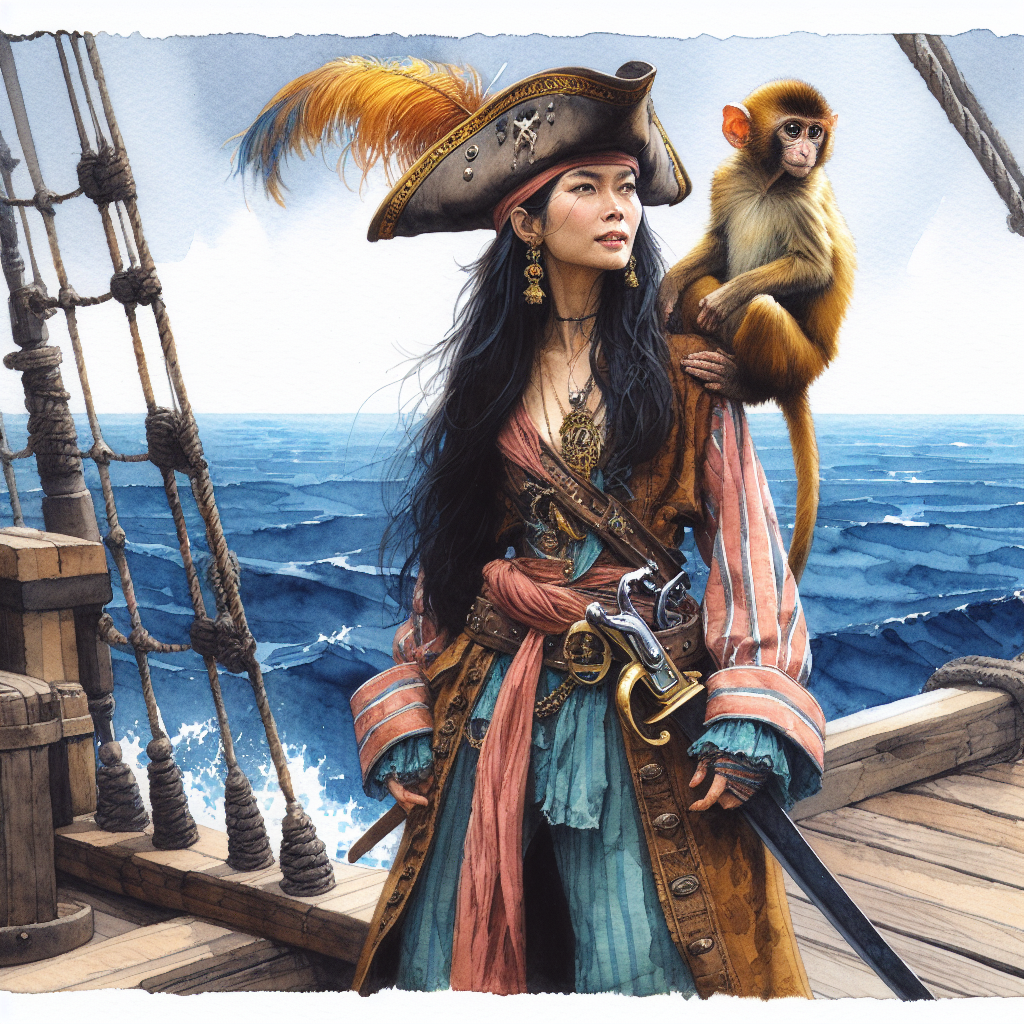

In [15]:
artist('monkey')

## The Grande Finale
Now, we bring everything together in one grand Gradio app!

The code below is self-contained and doesn't require running of any cells above. The code below uses the OpenAI LLMs only. 

Now, enjoy the grand finale!

In [16]:
import os
import json
import gradio as gr
from dotenv import load_dotenv

from openai import OpenAI
import google.generativeai
import anthropic

import random

import base64
from io import BytesIO
from PIL import Image
from IPython.display import Audio, display

load_dotenv(override=True)
openai_api_key = os.getenv('OPENAI_API_KEY')
openai = OpenAI()

In [17]:
pirate_quotes = [
    "May your blade always be wet, and powder dry.",
    "Under a black flag we sail and the sea shall be our empire.",
    "Ahoy matey! Let’s trouble the water!",
    "Under a black flag we shall sail.",
    "Obey the captain or learn to swim.",
    "I be ruler of the seven seas!",
    "Shiver me timbers!",
    "Avast, ye scurvy dog.",
    "Walk the plank, ye scallywag.",
    "Pillage and plunder.",
    "Batten down the hatches.",
    "Weigh anchor and hoist the mizzen.",
    "Here be treasure, matey.",
    "Thar she blows!",
    "Yo ho ho and a bottle of rum.",
    "Prepare to be boarded.",
    "May your anchor be tight, your cork be loose, your rum be spiced and your compass be true.",
    "Loot is first and wimmen second. Because if ye have the first ye’ll have the second, but if ye have the second ye won’t have the first for long!",
    "The rougher the seas, the smoother we sail. Ahoy!",
    "No cause is lost if there is but one fool left to fight for it.",
    "Avast ye landlubbers! Ye can throw ye lunch in Davy Jones’ locker, but not yer homework!"
]

def pirate_quoter(num_quotes):
    print('-----------------------------------------')
    print(f"{num_quotes} pirate quote(s) requested")
    selected_pirate_quotes = random.sample(pirate_quotes, num_quotes)
    print(selected_pirate_quotes)
    print('-----------------------------------------')
    return selected_pirate_quotes

def pet_namer(animal):
    print('-----------------------------------------')
    print(f"Name for a pet {animal} requested")
    messages = [
        {'role':'system', 'content':'You are a pirate. You will be given an animal, and you will decide on some pet names that you may give it if it was your pet. You will reply with only the pet names for this animal, separated by commas.'},
        {'role':'user',   'content':animal}
    ]
    response = openai.chat.completions.create(model='gpt-4o-mini', messages=messages)
    reply = response.choices[0].message.content
    suggested_pet_names = reply.replace('and ','').split(', ')
    print(suggested_pet_names)
    print('-----------------------------------------')
    return suggested_pet_names

pirate_quoter_tool = {
    "name": "pirate_quoter",
    "description": "Get random pirate quotes. Call this whenever you are asked for pirate quotes.",
    "parameters": {
        "type": "object",
        "properties": {
            "num_quotes": {
                "type": "integer",
                "description": "The number of pirate quotes requested by the user.",
            },
        },
        "required": ["num_quotes"],
        "additionalProperties": False
    }
}

pet_namer_tool = {
    "name": "pet_namer",
    "description": "Get a pet name for a given animal. Call this whenever you are asked to suggest a name for a pet.",
    "parameters": {
        "type": "object",
        "properties": {
            "animal": {
                "type": "string",
                "description": "The kind of animal for which to suggest a pet name.",
            },
        },
        "required": ["animal"],
        "additionalProperties": False
    }
}

tools = [{"type": "function", "function": pirate_quoter_tool}, {"type": "function", "function": pet_namer_tool}]

In [18]:
def talker(message):
    response = openai.audio.speech.create(
        model="gpt-4o-mini-tts",
        # model="tts-1",
        voice="ash",
        instructions="Speak with a thick pirate accent.",
        input=message)

    audio_stream = BytesIO(response.content)
    output_filename = "output_audio.mp3"
    with open(output_filename, "wb") as f:
        f.write(audio_stream.read())

    # Play the generated audio
    display(Audio(output_filename, autoplay=True))

def artist(animal):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"An image of a pirate with his or her favorite pet {animal}, in a classic watercolor painting style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

In [19]:
system_message = 'You are a pirate. You reply to questions in a thick pirate accent.'
def chat(history, pirate_pet_image):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model='gpt-4o-mini', messages=messages, tools=tools)
    # pirate_pet_image = None
    
    # handle tool calls
    if response.choices[0].finish_reason=="tool_calls":
        # add response to list of messages for upcoming API call (at the end of this if)
        message = response.choices[0].message
        messages.append(message)
        
        # loop over scheduled tool calls
        tool_calls = response.choices[0].message.tool_calls
        for i in range(len(tool_calls)):
            tool_call_i = tool_calls[i]
            tool_func_i = tool_call_i.function
            tool_name_i = tool_func_i.name
            tool_args_i = json.loads(tool_func_i.arguments)
            if tool_name_i == 'pirate_quoter':
                num_quotes = tool_args_i.get('num_quotes')
                response = {
                    "role": "tool",
                    "content": json.dumps({"num_quotes": num_quotes, "quotes": pirate_quoter(num_quotes)}),
                    "tool_call_id": tool_call_i.id
                }
            elif tool_name_i == 'pet_namer':
                animal = tool_args_i.get('animal')
                response = {
                    "role": "tool",
                    "content": json.dumps({"animal": animal, "pet_names": pet_namer(animal)}),
                    "tool_call_id": tool_call_i.id
                }
                pirate_pet_image = artist(animal)
            messages.append(response)

        # finalize tool calls
        response = openai.chat.completions.create(model='gpt-4o-mini', messages=messages)

    # return
    reply = response.choices[0].message.content
    talker(reply)
    history += [{"role":"assistant", "content":reply}]
    return history, pirate_pet_image

In [ ]:
# More involved Gradio code as we're not using the preset Chat interface!
with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    # last_image = gr.State(None)  # State to store the last valid image

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(
        do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]
    ).then(
        chat, inputs=[chatbot, image_output], outputs=[chatbot, image_output]
    )

    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

# Passing in inbrowser=True in the last line will cause a Gradio window to pop up immediately.
ui.launch(inbrowser=True)

# Examples:
# - Who is Davey Jones?
# - What are some animals that are usually taken as pets by pirates?
# - I am thinking of getting myself a pet dog. What should I name him?
# - Give me some pirate quotes

-------

# THE END
We leave it up to the reader as exercises to incorporate the use of tools and voice/image generation with Anthropic Claude and Google Gemini. You may also extend the above UI by adding a dropdown from which the user may select a particular voice for the `talker()` function.

Finally, an addition to this notebook that I would love to see is coming up with a more authentic pirate-accented voice output. Do let me know if you figure it out!